In [1]:
import networkx as nx
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import cdist

from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.common.coordinates import nadir_attitude
from craterdetection.matching.database import extract_robbins_dataset, load_craters, CraterDatabase
from craterdetection.matching.projective_invariants import crater_representation, CoplanarInvariants, scale_det
from craterdetection.matching.utils import cyclic_permutations, enhanced_pattern_shifting, is_clockwise, all_clockwise, \
    np_swap_columns, is_colinear, cw_or_ccw
from craterdetection.common.conics import *



In [2]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[4, 30], ellipse_limit=1.1)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [3]:
# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (45., 45.))
cam_alt = 500

cam = Camera.from_coordinates(cam_lat, cam_long, cam_alt, resolution=(256, 256))

cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', 5, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2)*1.0)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(C_craters, r_craters)

crater_centers = cam.project_crater_centers(r_craters)
#
# detection_order = np.argsort(cdist(crater_centers, np.array(cam.resolution)[None, :]/2).squeeze())
# crater_centers = crater_centers[detection_order]
# A_craters = A_craters[detection_order]

C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.


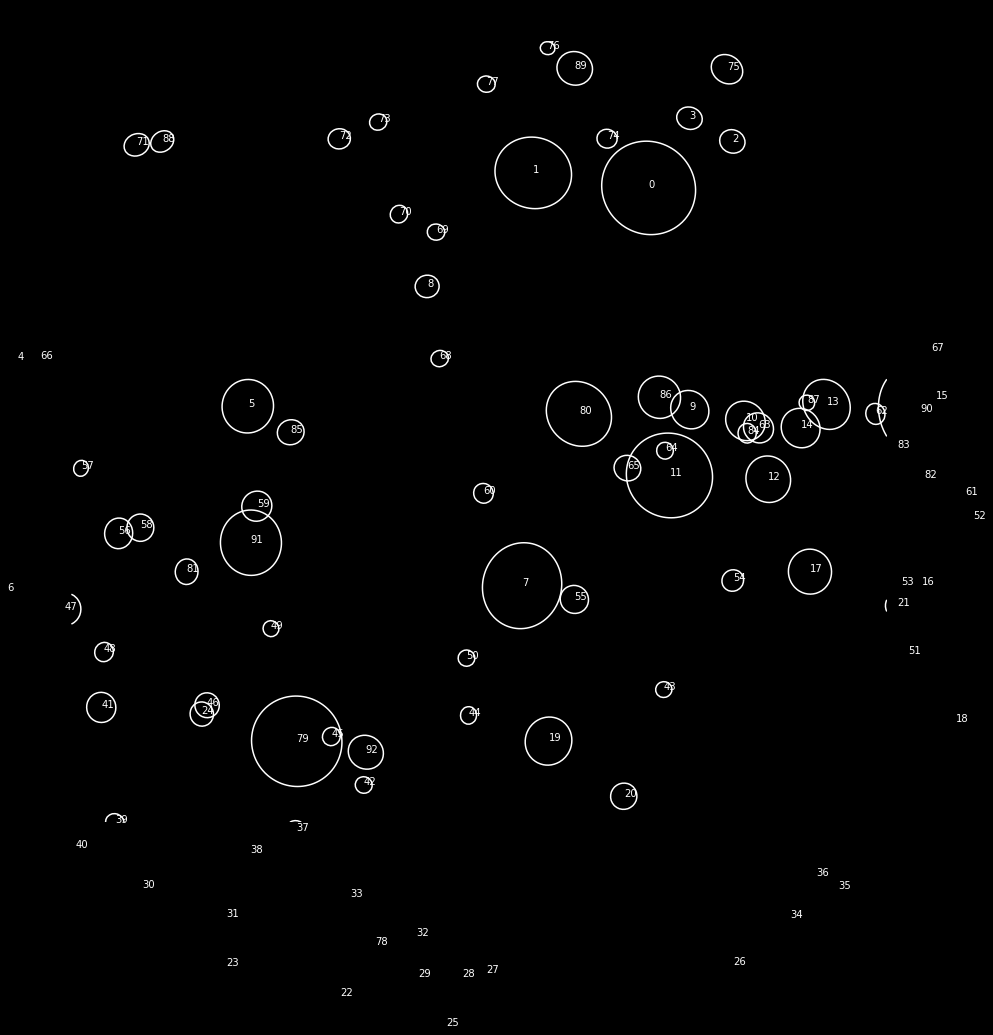

In [4]:
plt.style.use('dark_background')
x_plot = np.linspace(0, cam.resolution[0], 300)
y_plot = np.linspace(0, cam.resolution[1], 300)
x_plot, y_plot = np.meshgrid(x_plot, y_plot)

xy_homogeneous = np.concatenate(
    (
        x_plot.ravel()[None, :],
        y_plot.ravel()[None, :],
        np.ones_like(x_plot.ravel()[None, :])
    ),
    axis=0
).T[..., None]

# c = xy_homogeneous.transpose(0, 2, 1) @ A_i[:, None, ...] @ xy_homogeneous
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'aspect': 'equal'})
# Set axes according to camera pixel space convention



for a_i in A_craters:
    c = xy_homogeneous.transpose(0, 2, 1) @ scale_det(a_i) @ xy_homogeneous
    ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0], colors='w')
for k, c_i in enumerate(crater_centers):
    x, y = c_i[0], c_i[1]
    if x <= 1000 and y <=1000:
        ax.text(x, y, str(k))
ax.set_xlim(0, cam.resolution[0])
ax.set_ylim(cam.resolution[1], 0)
ax.set_axis_off()
# fig.tight_layout()

In [14]:
# db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv", latlims=[40, 50], longlims=[40, 50], radius=500)
db = CraterDatabase(lat_cat[vicinity], long_cat[vicinity], major_cat[vicinity], minor_cat[vicinity], psi_cat[vicinity], radius=500)

In [19]:
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = 0
max_iter = 1e1
for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters)):
    p = features
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)

        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)
        # match = np.argmin(diff)
        # print(np.min(diff))

        if np.min(diff) < max_diff:
            min_idx = np.argwhere(diff <= max_diff)[0]

            subset_match = np.logical_and.reduce(lat_cat[vicinity][crater_triad[order]] \
                                                                             == db.get_position(min_idx)[0].T, axis=1)
            # print(subset_match)
            if np.logical_or.reduce(subset_match):
                print(f"MATCH [{i}]")
                match = min_idx[np.where(subset_match)].item()
                print(crater_triad)
                print(order_full)
                print(f"\tMean difference: {diff[match]:.2%}, position: {np.where(subset_match)[0].item()}")

                print("\tDetection feature: \t", p[order_full])
                print("\tDB match feature: \t", db.features[match])

                print("\tCrater triad coords: \t", lat_cat[vicinity][crater_triad[order]], long_cat[vicinity][crater_triad[order]])
                print("\tDB match coords: \t", *db.get_position(match))
                correct_matches += 1
                print()
                break

    if i >= max_iter:
        break

MATCH [0]
[1 0 2]
[ 0  1  2  3  4  5 -1]
	Mean difference: 0.56%, position: 0
	Detection feature: 	 [  -5.235   -5.484 -118.042   -3.608  -19.18   -55.121 -137.088]
	DB match feature: 	 [  -5.217   -5.464 -119.475   -3.629  -19.336  -54.99  -137.609]
	Crater triad coords: 	 [0.885 0.879 0.893] [0.812 0.867 0.911]
	DB match coords: 	 [0.885 0.879 0.893] [0.812 0.867 0.911]

MATCH [3]
[10  9 11]
[ 0  1  2  3  4  5 -1]
	Mean difference: 0.32%, position: 0
	Detection feature: 	 [ -5.219  -3.755  -4.976  -5.333  -0.884  -9.828 -37.081]
	DB match feature: 	 [ -5.233  -3.771  -4.965  -5.321  -0.881  -9.884 -37.161]
	Crater triad coords: 	 [0.806 0.81  0.791] [0.9   0.876 0.865]
	DB match coords: 	 [0.806 0.81  0.791] [0.9   0.876 0.865]

MATCH [4]
[12 13 14]
[ 0  1  2  3  4  5 -1]
	Mean difference: 0.97%, position: 0
	Detection feature: 	 [-15.673   0.519  -5.763 -13.36   -0.116  -5.121 -48.544]
	DB match feature: 	 [-15.618   0.516  -5.785 -13.43   -0.111  -5.107 -48.642]
	Crater triad coord

In [7]:
correct_matches

26

In [10]:
max_iter = 20
for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters)):
    print(crater_triad)

    for order, crater_triad_cyc in zip(cyclic_permutations(np.arange(3)), cyclic_permutations(crater_triad)):
        order_full = np.append(np.concatenate((order, order+3)), -1)
        idx = np.where(np.logical_and.reduce(db.crater_triads == crater_triad_cyc, axis=1))[0]

        if len(idx) != 0:
            idx = idx.item()
            print(idx)
            print("\t\t", features[order_full])
            print("\t\t", db.features[idx])
            diff = np.mean(np.abs(((db.features[idx] - features[order_full])/features[order_full])))
            print(f"Difference: {diff:.2%}")
            print()
    if i >= max_iter:
        break

[1 0 2]
0
		 [  -5.23463015   -5.48438711 -118.04190881   -3.60756251  -19.17981823
  -55.12052344 -137.08785199]
		 [  -5.21689328   -5.46422903 -119.47502954   -3.62888717  -19.33637797
  -54.98969585 -137.60937964]
Difference: 0.56%

[3 4 5]
12010
		 [-2442.07412206  -114.96316044  -700.69604908 -1695.6251051
   -96.99177752 -1141.58754743 -4879.19722175]
		 [-2565.00006137  -116.11261666  -726.52135568 -1810.10351878
   -97.28825805 -1169.42947424 -5147.21783884]
Difference: 3.53%

[6 7 8]
22984
		 [ -400.5677861   -137.77804243 -1326.67808432  -259.29735895
  -293.64260956  -845.91052472 -2964.64538688]
		 [ -416.17099847  -138.97304215 -1355.83797794  -264.2791924
  -298.30385614  -875.89541725 -3085.42105735]
Difference: 2.58%

[10  9 11]
33366
		 [ -5.21907439  -3.75503873  -4.97638987  -5.33345472  -0.8837855
  -9.82835479 -37.08087763]
		 [ -5.23345051  -3.77123879  -4.96508201  -5.32109618  -0.88138736
  -9.88417606 -37.16074307]
Difference: 0.32%

[12 13 14]
43252
		 [-15.6

In [7]:
db.features[idx]

array([], shape=(0, 7), dtype=float64)

In [9]:
db.features[1358][None, :]

array([[ -232.156,  -279.696,  -332.983,  -337.911,  -269.95 ,  -252.231,
        -1702.14 ]])

In [10]:
CoplanarInvariants.from_detection_conics(A_craters=A_craters).crater_triads.shape

(129675, 3)

In [11]:
def get_cliques_by_length(G, length_clique):
    """ Return the list of all cliques in an undirected graph G with length
    equal to length_clique. """
    cliques = []
    for c in nx.enumerate_all_cliques(G) :
        if len(c) <= length_clique:
            if len(c) == length_clique:
                cliques.append(c)
        else:
            return cliques
    # return empty list if nothing is found
    return cliques

crater_triads_cl = np.array(get_cliques_by_length(db._graph, 3))

In [12]:
len(crater_triads_cl)


12358

In [13]:
crater_triads_cl

array([[ 0,  1,  2],
       [ 0,  1,  3],
       [ 0,  1,  8],
       ...,
       [84, 87, 90],
       [85, 91, 92],
       [86, 87, 90]])